# **Parameter Optimisation for GITT** 

This notebook is created to provide an example for ```GITT``` optimisation problem. Diffisuion Coefficient is optimised in this notebook. 24 seperate discharge pulses are used in here.
 The workflow is as follows:


In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q # For Colab use
import pybamm
import pbparam
import pandas as pd
import os
import numpy as np

pulse_folder_path = (os.path.join(pbparam.__path__[0], "input", "data/GITT"))
OCP_folder_path = (os.path.join(pbparam.__path__[0], "input", "data"))

# Get a list of all files in the folder
all_files = os.listdir(pulse_folder_path)

# Filter the list to get only .csv files
csv_files = [file for file in all_files if file.endswith('.csv')]

In [2]:
# Extract pulse numbers from filenames and sort them
pulse_numbers = [int(file_name.split('_')[1].split('.csv')[0]) for file_name in csv_files]
sorted_files_by_pulse = [f"pulse_{num}.csv" for num in sorted(pulse_numbers)]

# Loop through each CSV file and read it into a DataFrame
dfs = {}  # Store each DataFrame in a dictionary with the filename as the key

for csv_file in sorted_files_by_pulse:
    file_path = os.path.join(pulse_folder_path, csv_file)
    dfs[csv_file] = pd.read_csv(file_path)

In [3]:
# Reading half cell data for OCP balance
cathode_half_lit = pd.read_csv(os.path.join(OCP_folder_path,"cathode_OCP_2_lit.csv")) # Half cell lithiation data
cathode_half_delit = pd.read_csv(os.path.join(OCP_folder_path,"cathode_OCP_2_delit.csv")) # Half cell delithiation data

In [4]:
## OPTIONAL ##

# Calculation of Charge (Q)

def compute_cumulative_charge(currents, times, starting_charge):
    q_values = [starting_charge]
    for i in range (1, len(currents)):
        dt = times[i] - times[i-1]
        dq = 0.5 * np.abs(currents[i]+currents[i-1]) * dt
        q_values.append(q_values[-1] + dq)
    return q_values

In [5]:
# Charges are calculated and added as a new column to the dataframe.
starting_charge = 0
for name, df in dfs.items():
    currents = df["Current [A]"].tolist()
    times = df["Time [s]"].tolist()
    q_values = compute_cumulative_charge(currents, times, starting_charge)
    starting_charge = q_values[-1]
    dfs[name]['Charge (Q)'] = q_values

In [6]:
# Individual pulses can be printed as below.
dfs["pulse_1.csv"]

,Time [s],Voltage [V],Current [A],Negative electrode potential [V],Positive electrode potential [V],Charge (Q)
0,105749.3767,4.147639,0.000000e+00,0.090113,4.237751,0.000000e+00
1,105809.3769,4.147734,0.000000e+00,0.090017,4.237751,0.000000e+00
2,105869.3771,4.147772,0.000000e+00,0.089998,4.237771,0.000000e+00
3,105927.2243,4.147811,0.000000e+00,0.089998,4.237809,0.000000e+00
4,105927.2727,4.147582,-5.790000e-07,0.089998,4.237580,1.401180e-08
...,...,...,...,...,...,...
90,107185.0980,4.110606,0.000000e+00,0.092632,4.203238,1.035021e+03
91,107226.1511,4.111618,0.000000e+00,0.092193,4.203811,1.035021e+03
92,107286.1513,4.111560,0.000000e+00,0.092193,4.203754,1.035021e+03
93,107346.1515,4.111942,0.000000e+00,0.092041,4.203982,1.035021e+03


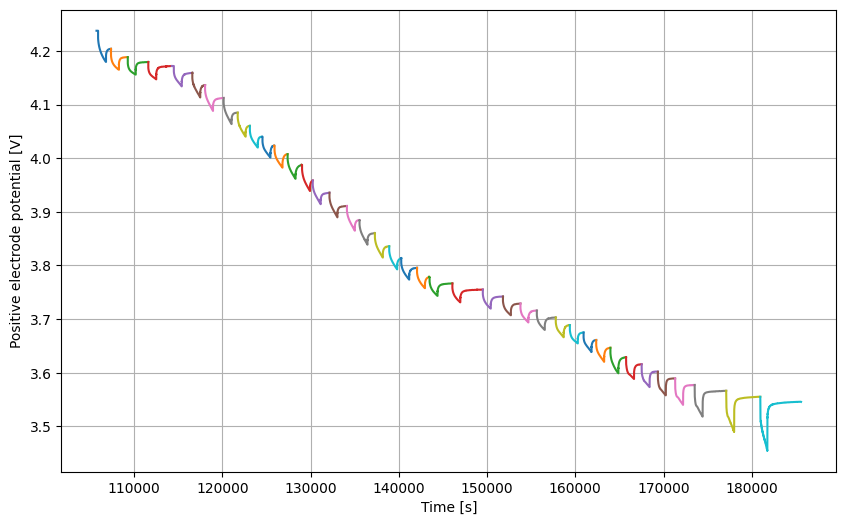

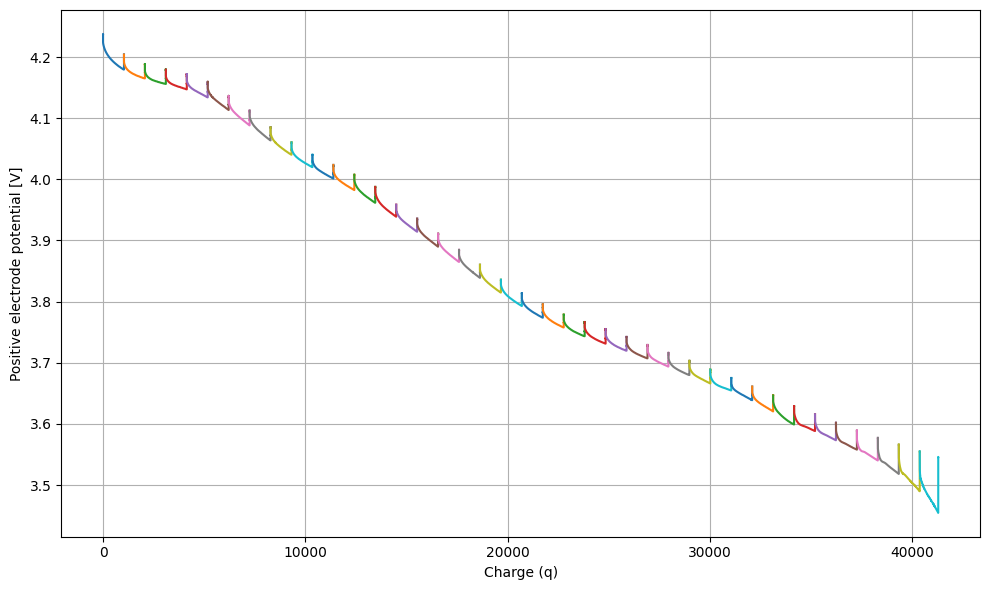

In [7]:
# Both of the Voltage vs Time and Charge can be plotted as below.

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
fig2, ax2 =plt.subplots(figsize=(10, 6))
for file_name, df in dfs.items():
    ax.plot(df['Time [s]'], df["Positive electrode potential [V]"])
    ax2.plot(df['Charge (Q)'], df["Positive electrode potential [V]"])
ax.set_xlabel('Time [s]')
ax2.set_xlabel('Charge (q)')
ax.set_ylabel('Positive electrode potential [V]')
ax2.set_ylabel('Positive electrode potential [V]')
ax.grid(True)
ax2.grid(True)
plt.tight_layout()
plt.show()

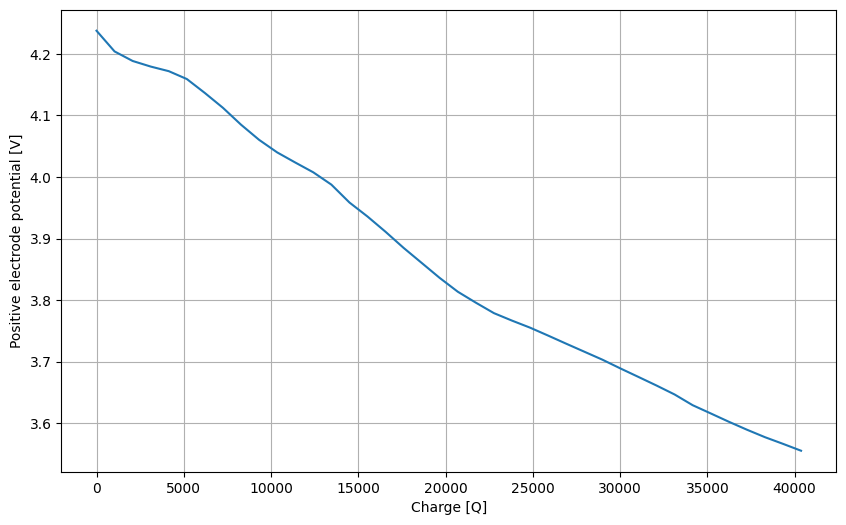

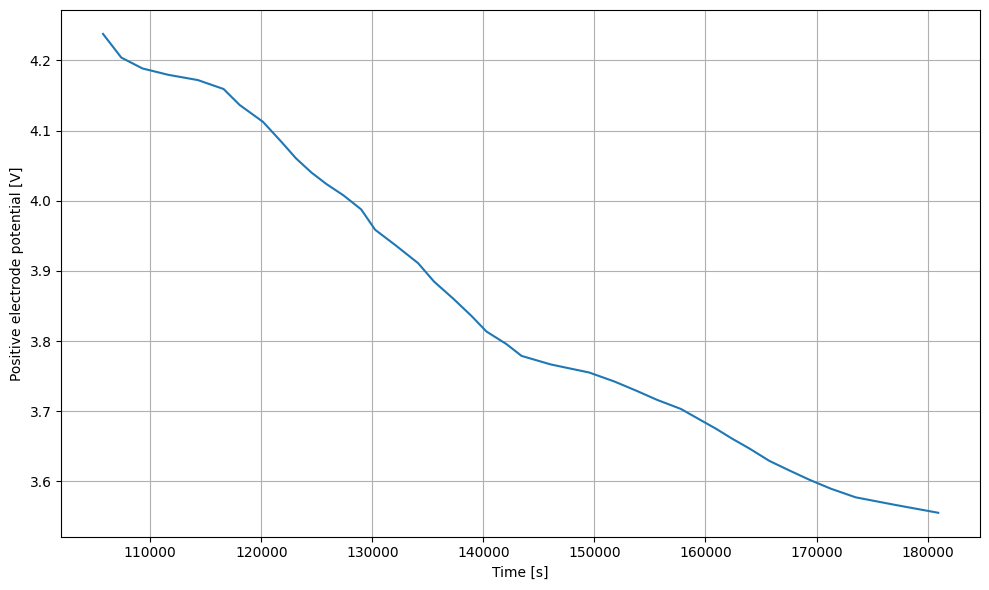

In [8]:
# Create a list to collect the first value from each DataFrame
first_values = [df['Positive electrode potential [V]'][0] for _, df in dfs.items()] # saving the first values of each pulse.
time_val = [df['Time [s]'][0] for _, df in dfs.items()]
charge_val = [df['Charge (Q)'][0] for _, df in dfs.items()]

fig, ax = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))

ax.plot(charge_val,first_values)
ax2.plot(time_val,first_values)
ax2.set_xlabel('Time [s]')
ax.set_xlabel('Charge [Q]')
ax.set_ylabel('Positive electrode potential [V]')
ax2.set_ylabel('Positive electrode potential [V]')
ax.grid(True)
ax2.grid(True)
plt.tight_layout()
plt.show()

In [9]:

pulse_values= pd.DataFrame(data={'Charge [Ah]': charge_val, 'Voltage [V]':first_values})
ocp_balance_cathode = pbparam.OCPBalance(
    [cathode_half_lit, cathode_half_delit],
    [pulse_values, pulse_values],
    
    # cost_function=pbparam.MLE(),
)

In [10]:
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")


In [11]:
result_cathode = optimiser.optimise(ocp_balance_cathode)

In [12]:
print("Cathode Results: ",result_cathode)

Cathode Results:  
             Optimal values: [-16855.38483151  60799.21274656]
        Cost function value: 0.004787343288355471
                 Solve time: 77.920 ms
                    Message: Optimization terminated successfully.
        


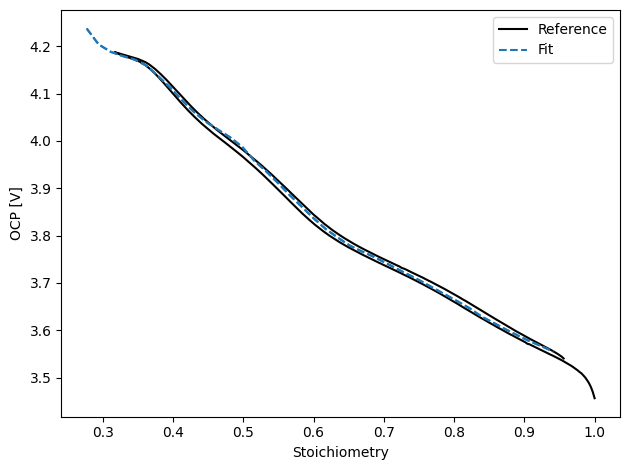

In [13]:
result_cathode.plot();

In [14]:
# For BasicGITT, we need derivatives of each pulse which can be calculated as:
import numpy as np
grad = np.gradient(first_values,charge_val)/result_cathode.x[1]

PbParam model to be used for GITT needs to be defined:

In [15]:
model = pbparam.BasicGITT()

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower errors for most of the cases. 

In [16]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

Next, parameter dictionary needs to be defined with all of the required parameters:

In [17]:
param_dict=pybamm.ParameterValues({
        "Reference OCP [V]": first_values[0],
        "Derivative of the OCP wrt stoichiometry [V]": grad[0],
        "Current function [A]": 0.680616,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Electrode width [m]": 0.207,
        "Electrode height [m]": 0.137,
        "Positive electrode active material volume fraction": 0.5,
        "Positive particle radius [m]": 1e-05,
        "Positive electrode thickness [m]": 0.0001,
        "Positive electrode diffusivity [m2.s-1]": 5e-14,
        "Maximum concentration in positive electrode [mol.m-3]": 51217.9257309275,
        "Initial concentration in positive electrode [mol.m-3]": 1000,
        "Effective resistance [Ohm]": 0,
        'Negative electrode thickness [m]': 0.0001,
        'Separator thickness [m]': 0.0001,
        'Negative particle radius [m]': 1e-05,
    })

The Diffusuvity is optimised for every pulse in a loop as below:

In [18]:
i = 0
results = []
diffusions = []
for name, df in dfs.items():
    #Parameter dictionary updated for every pulse
    param_dict.update({
        "Reference OCP [V]": first_values[i],
        "Derivative of the OCP wrt stoichiometry [V]": grad[i],
    })
    # Time [s] should start from 0 for every pulse! (Otherwise it will NOT work!)
    df['Time [s]'] = df['Time [s]']-df['Time [s]'][0]

    # We are doing this for positive electrode potential 
    # but it needs to be converted to 'Voltage [V]'
    pulse_data = df.filter(items=['Time [s]', 'Positive electrode potential [V]'])
    pulse_data.rename(columns={'Positive electrode potential [V]': 'Voltage [V]'}, inplace=True)

    # Optimisation problem is defined here.
    opt = pbparam.GITT(param_dict=param_dict,gitt_model=model, data=pulse_data)

    #Optimisation is done in step and saved in result.
    result = optimiser.optimise(opt)

    # Diffisuion coefficient is the first one in the result.
    diffusions.append(result.x[0])

    # They can be plotted using:
    #result.plot()

    # All of the results are stored.
    results.append(result) 
    i +=1

In [24]:
diffusions
# plt.plot(diffusions)

[2.06e-16,
 2.6256359829576133e-16,
 5.688290995715811e-15,
 1.3896511183747269e-14,
 3.5628125224623317e-16,
 2.06e-16,
 3.07384711192395e-16,
 2.06e-16,
 2.06e-16,
 2.06e-16,
 2.06e-16,
 2.06e-16,
 2.06e-16,
 2.06e-16,
 5.1177531363200515e-14,
 2.8057526691284114e-16,
 2.06e-16,
 2.2539688340219275e-16,
 2.06e-16,
 2.06e-16,
 2.372199078458537e-16,
 2.06e-16,
 4.266028895421232e-16,
 5.733827022300412e-15,
 3.498737550576556e-16,
 2.826586256592222e-16,
 2.524788336291686e-16,
 3.246380957273257e-16,
 2.06e-16,
 2.06e-16,
 2.06e-16,
 2.06e-16,
 2.333743123784969e-16,
 5.2087892835356755e-14,
 5.192896794375209e-14,
 5.132560208004831e-14,
 5.1849673378264197e-14,
 5.2015981366096424e-14,
 2.06e-16,
 5.300389217969984e-14]